In [45]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, recall_score

from xgboost import XGBClassifier
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
path = Path.cwd().parents[0] / 'output/vote_result.xlsx'
df = pd.read_excel(path)

In [47]:
def preprocess_df(df):
    return (df
        .drop(columns='nama')
    )

df_clean = preprocess_df(df)

NUM_COLS = ['vote', 'no_urut', 'partai_vote']
CAT_COLS = ['dapil_no', 'dapil_nama', 'partai']
TARGET = ['terpilih']

assert sorted(NUM_COLS + CAT_COLS + TARGET) == sorted(df_clean.columns)

x = df_clean[NUM_COLS + CAT_COLS]
y = df_clean[TARGET]

# First Try

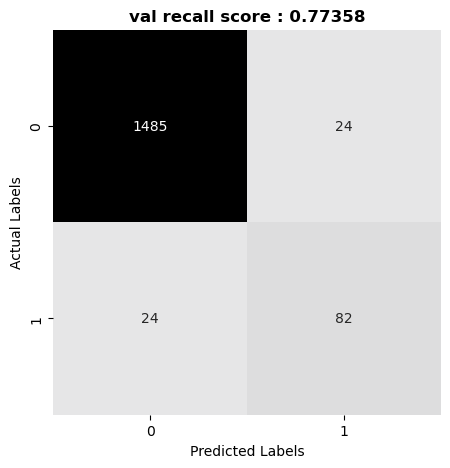

In [48]:
# preprocessing pipeline
numerical_pipe = Pipeline([
    ('scale', StandardScaler())
])
categorical_pipe = Pipeline([
    ('encode', OneHotEncoder(sparse_output=False)), 
    ('scale', StandardScaler())
])
pipe = ColumnTransformer([
    ("numerical", numerical_pipe, NUM_COLS),
    ("categorical", categorical_pipe, CAT_COLS)
])

# prediction pipeline
prediction= Pipeline([
    ('model', XGBClassifier())
])

# full pipeline
pipeline= Pipeline([
    ('preprocessing', pipe),
    ('prediction', prediction)
])

# fold
fold= StratifiedKFold(
    n_splits= 5, 
    shuffle= True, 
    random_state= 8
)

# training
y_pred= cross_val_predict(
    estimator = pipeline, 
    cv= fold, 
    X= x, 
    y= y, 
    n_jobs= -1, 
    verbose= 0
)

# confusion matrix
val_score = recall_score(y, y_pred)
cm = confusion_matrix(y, 
                      y_pred, 
                    #   normalize='true'
                      )

plt.figure(figsize=(5, 5))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, cmap=cmap, cbar=False, fmt='.0f')

plt.title(f'val recall score : {val_score:.5f}', fontweight='bold')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

plt.show()

# HP Tuning

In [49]:
def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # preprocessing pipeline
    numerical_pipe = Pipeline([
        ('scale', StandardScaler())
    ])
    categorical_pipe = Pipeline([
        ('encode', OneHotEncoder(sparse_output=False)), 
        ('scale', StandardScaler())
    ])
    pipe = ColumnTransformer([
        ("numerical", numerical_pipe, NUM_COLS),
        ("categorical", categorical_pipe, CAT_COLS)
    ])

    # prediction pipeline
    prediction= Pipeline([
        ('model', XGBClassifier(**param))
    ])

    # full pipeline
    pipeline= Pipeline([
        ('preprocessing', pipe),
        ('prediction', prediction)
    ])

    # fold
    fold= StratifiedKFold(
        n_splits= 5, 
        shuffle= True, 
        random_state= 8
    )
    
    # training
    y_pred= cross_val_predict(
        estimator = pipeline, 
        cv= fold, 
        X= x, 
        y= y, 
        n_jobs= -1, 
        verbose= 0
    )
    
    val_recall_score = recall_score(y, y_pred)
    return val_recall_score


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1_000, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-09-04 21:46:43,669] A new study created in memory with name: no-name-c01bf25d-bb66-40f7-a0a4-4d1d232b26cd
[I 2023-09-04 21:46:44,925] Trial 0 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 6.52380658748858e-07, 'alpha': 0.003346994376495859, 'subsample': 0.5043581509138884, 'colsample_bytree': 0.20509464206791403, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.015415905507180356, 'gamma': 8.295858567289484e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.01590064998955946, 'skip_drop': 0.00985669563761336}. Best is trial 0 with value: 0.0.
[I 2023-09-04 21:46:45,497] Trial 1 finished with value: 0.6132075471698113 and parameters: {'booster': 'gblinear', 'lambda': 0.005874951911853867, 'alpha': 1.1808449176836918e-08, 'subsample': 0.6309824075591273, 'colsample_bytree': 0.8706616302214747}. Best is trial 1 with value: 0.6132075471698113.
[I 2023-09-04 21:46:46,119] Trial 2 finished with value: 0.02830

Number of finished trials:  1000
Best trial:
  Value: 0.8490566037735849
  Params: 
    booster: dart
    lambda: 2.9541979268506014e-06
    alpha: 0.06720709377622727
    subsample: 0.2822713436169264
    colsample_bytree: 0.8015493370458756
    max_depth: 5
    min_child_weight: 7
    eta: 0.9926862707555301
    gamma: 3.450775782531027e-07
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: tree
    rate_drop: 3.790317728677361e-07
    skip_drop: 3.2343290641852286e-05


In [50]:
trial.params

{'booster': 'dart',
 'lambda': 2.9541979268506014e-06,
 'alpha': 0.06720709377622727,
 'subsample': 0.2822713436169264,
 'colsample_bytree': 0.8015493370458756,
 'max_depth': 5,
 'min_child_weight': 7,
 'eta': 0.9926862707555301,
 'gamma': 3.450775782531027e-07,
 'grow_policy': 'depthwise',
 'sample_type': 'uniform',
 'normalize_type': 'tree',
 'rate_drop': 3.790317728677361e-07,
 'skip_drop': 3.2343290641852286e-05}

# Try with Tuned HP

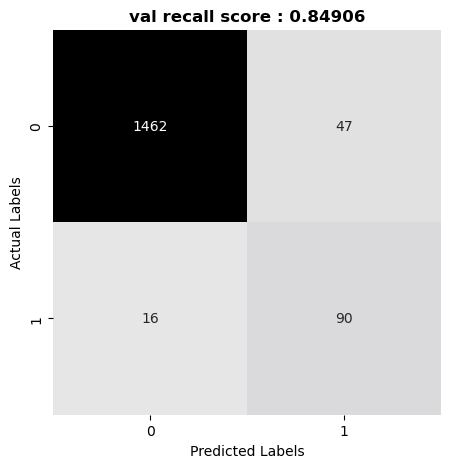

In [51]:
# preprocessing pipeline
numerical_pipe = Pipeline([
    ('scale', StandardScaler())
])
categorical_pipe = Pipeline([
    ('encode', OneHotEncoder(sparse_output=False)), 
    ('scale', StandardScaler())
])
pipe = ColumnTransformer([
    ("numerical", numerical_pipe, NUM_COLS),
    ("categorical", categorical_pipe, CAT_COLS)
])

# prediction pipeline
prediction= Pipeline([
    ('model', XGBClassifier(**trial.params))
])

# full pipeline
pipeline= Pipeline([
    ('preprocessing', pipe),
    ('prediction', prediction)
])

# fold
fold= StratifiedKFold(
    n_splits= 5, 
    shuffle= True, 
    random_state= 8
)

# training
y_pred= cross_val_predict(
    estimator = pipeline, 
    cv= fold, 
    X= x, 
    y= y, 
    n_jobs= -1, 
    verbose= 0
)

# confusion matrix
val_score = recall_score(y, y_pred)
cm = confusion_matrix(y, 
                      y_pred, 
                    #   normalize='true'
                      )

plt.figure(figsize=(5, 5))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, cmap=cmap, cbar=False, fmt='.0f')

plt.title(f'val recall score : {val_score:.5f}', fontweight='bold')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

plt.show()